In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
cd ../src

/home/theo/mva/dlmi/pneumothorax_segmentation/src


In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
from util import *
from metric import *
from params import *
from imports import *

<IPython.core.display.Javascript object>

In [5]:
from data.masks import *
from data.dataset import *
from data.transforms import *

<IPython.core.display.Javascript object>

In [41]:
from training.train import *
from training.freezing import *
from training.losses import *

<IPython.core.display.Javascript object>

In [8]:
from model_zoo.unet import *

<IPython.core.display.Javascript object>

In [9]:
from tqdm import tqdm_notebook as tqdm

sns.set_style("white")
KERNEL_START_TIME = time.time()
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=RuntimeWarning)
print("Number of available cores :", multiprocessing.cpu_count())

Number of available cores : 16


<IPython.core.display.Javascript object>

In [10]:
seed_everything(seed)

<IPython.core.display.Javascript object>

# Data

In [11]:
df = pd.read_csv("../output/df_train.csv")

<IPython.core.display.Javascript object>

In [12]:
ratio = 4

<IPython.core.display.Javascript object>

### Balance

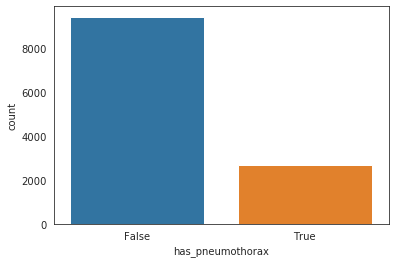

<IPython.core.display.Javascript object>

In [13]:
sns.countplot(df["has_pneumothorax"])
plt.show()

In [14]:
count_pos = len(df[df["has_pneumothorax"] == 1])
count_neg = len(df[df["has_pneumothorax"] == 0])

idx_drop = np.random.choice(
    df[df["has_pneumothorax"] == 0].index, count_neg - count_pos, replace=False
)
df.drop(idx_drop, inplace=True, axis=0)

<IPython.core.display.Javascript object>

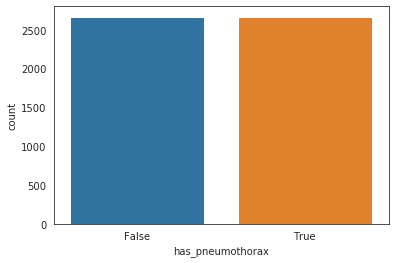

<IPython.core.display.Javascript object>

In [15]:
sns.countplot(df["has_pneumothorax"])
plt.show()

## Training

In [26]:
def fit_seg(
    model,
    train_dataset,
    val_dataset,
    epochs=50,
    batch_size=32,
    use_aux_clf=True,
    acc_steps=1,
    lr=1e-3,
    min_lr=1e-5,
    verbose=1,
    use_lovasz=False,
):

    avg_val_loss = 1000

    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=min_lr)

    if use_lovasz:
        loss_seg = lov_loss
    else:
        loss_seg = nn.BCEWithLogitsLoss(reduction="mean")
    loss_clf = nn.BCEWithLogitsLoss(reduction="mean")
    loss_clf_w = 0.1

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        start_time = time.time()

        scheduler.step()
        lr = optimizer.param_groups[-1]["lr"]
        optimizer.zero_grad()

        for step, (x, mask, y) in enumerate(train_loader):
            mask_pred, y_pred = model(x.cuda())

            loss = loss_seg(mask_pred, mask.cuda())
            if use_aux_clf:
                loss += loss_clf(y_pred, y.cuda().float()) * loss_clf_w

            loss.backward()
            avg_loss += loss.item() / len(train_loader)

            if step % acc_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        model.eval()

        avg_val_loss = 0.0
        val_dice = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for x, mask, y in val_loader:
                mask_pred, y_pred = model(x.cuda())

                loss = loss_seg(mask_pred.detach(), mask.cuda())
                if use_aux_clf:
                    loss += loss_clf(y_pred.detach(), y.cuda().float()) * loss_clf_w

                avg_val_loss += loss.item() / len(val_loader)
                mask_pred = torch.sigmoid(mask_pred.detach())
                y_pred = torch.sigmoid(y_pred.detach())

                val_acc += accuracy_score(y_pred.detach().cpu() > 0.5, y) / len(
                    val_loader
                )
                val_dice += dice_th(mask_pred.contiguous().cpu(), mask) / len(
                    val_loader
                )

        elapsed_time = time.time() - start_time

        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            print(
                f"Epoch {epoch + 1}/{epochs}   lr={lr:.1e}   t={elapsed_time:.0f}s   loss={avg_loss:.3f}   ",
                end="",
            )
            print(
                f"dice={val_dice:.3f}   val_loss={avg_val_loss:.3f}   val_acc={val_acc:.3f}"
            )

    del mask_pred, y_pred, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()

<IPython.core.display.Javascript object>

In [27]:
def model_training(
    backbone, df_train, df_val, ratio=4, seed=2020, save=False, **hparams,
):
    seed_everything(seed)

    center_block = "aspp" if hparams["use_aspp"] else "std"
    attention_type = "scse" if hparams["use_scse"] else None

    model = SegmentationUnet(
        SETTINGS[backbone],
        num_classes=1,
        center_block=center_block,
        aux_clf=True,
        use_hypercolumns=hparams["use_hypercolumns"],
        attention_type=attention_type,
    ).cuda()

    train_dataset = PneumoDataset(df_train, transforms=get_transfos(), ratio=ratio)
    val_dataset = PneumoDataset(df_val, transforms=None, ratio=ratio)

    freeze_encoder(model)
    n_parameters = count_parameters(model)
    print(f"\n - Training with frozen encoder")
    print(f"\t -> {n_parameters} trainable parameters\n")

    fit_seg(
        model,
        train_dataset,
        val_dataset,
        epochs=hparams["epoch_frozen"],
        batch_size=hparams["batch_size"],
        lr=hparams["lr_frozen"],
        min_lr=hparams["lr_min_frozen"],
        use_lovasz=hparams["use_lovasz"],
        use_aux_clf=True,
        verbose=1,
    )

    unfreeze_encoder(model)
    n_parameters = count_parameters(model)
    print(f"\n - Training full model")
    print(f"\t -> {n_parameters} trainable parameters\n")

    fit_seg(
        model,
        train_dataset,
        val_dataset,
        epochs=hparams["epoch"],
        batch_size=hparams["batch_size"],
        lr=hparams["lr"],
        min_lr=hparams["lr_min"],
        use_aux_clf=True,
        verbose=1,
    )

    if save:
        save_model_weights(model, f"unet_{backbone}_{i + 1}_1.pt", verbose=1)

<IPython.core.display.Javascript object>

# Training

In [28]:
backbone = "resnet34"

<IPython.core.display.Javascript object>

In [29]:
y = df["has_pneumothorax"].values

<IPython.core.display.Javascript object>

In [30]:
splits = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=seed).split(y, y))
train_idx, val_idx = splits[0]

<IPython.core.display.Javascript object>

In [31]:
df_train = df.iloc[train_idx]
df_val = df.iloc[val_idx]

<IPython.core.display.Javascript object>

In [32]:
train_dataset = PneumoDataset(df_train, transforms=get_transfos(), ratio=ratio)
val_dataset = PneumoDataset(df_val, transforms=None, ratio=ratio)

<IPython.core.display.Javascript object>

In [39]:
hparams = {
    "batch_size": 32,
    "lr_frozen": 1e-3,
    "lr_min_frozen": 1e-4,
    "epoch_frozen": 10,
    "epoch": 20,
    "lr": 1e-4,
    "lr_min": 1e-5,
    "use_lovasz": True,
    "use_hypercolumns": False,
    "use_aspp": False,
    "use_scse": False,
}

<IPython.core.display.Javascript object>

In [ ]:
assert torch.cuda.is_available(), "Training on GPU is mandatory"

model_training(
    backbone, df_train, df_val, ratio=ratio, seed=seed, save=False, cp=False, **hparams
)


 - Training with frozen encoder
	 -> 5378178 trainable parameters

Epoch 1/10   lr=9.8e-04   t=27s   loss=3.804   dice=0.430   val_loss=1.556   val_acc=0.667


**Tuning LR/ epochs**

1e-3 / 1e-4 / 5 / 10 : acc=0.862, dice=0.779
1e-3 / 1e-4 / 5 / 20 : acc=0.870, dice=0.785

In [56]:
hparams = {
    "batch_size": 32,
    "lr_frozen": 1e-3,
    "lr_min_frozen": 1e-4,
    "epoch_frozen": 5,
    "epoch": 20,
    "lr": 1e-4,
    "lr_min": 1e-5,
}
model_training(
    backbone, df_train, df_val, ratio=ratio, seed=seed, save=False, cp=False, **hparams
)


 - Training with frozen encoder 
	 -> 4920450 trainable parameters

Epoch 1/5   lr=9.1e-04   t=39s   loss=2.057   dice=0.012   val_loss=0.532   val_acc=0.579
Epoch 2/5   lr=6.9e-04   t=39s   loss=0.351   dice=0.004   val_loss=0.240   val_acc=0.688
Epoch 3/5   lr=4.1e-04   t=39s   loss=0.207   dice=0.013   val_loss=0.181   val_acc=0.699
Epoch 4/5   lr=1.9e-04   t=39s   loss=0.169   dice=0.063   val_loss=0.163   val_acc=0.702
Epoch 5/5   lr=1.0e-04   t=39s   loss=0.154   dice=0.116   val_loss=0.153   val_acc=0.710

 - Training full model 
	 -> 26188098 trainable parameters

Epoch 1/20   lr=9.9e-05   t=41s   loss=0.142   dice=0.217   val_loss=0.139   val_acc=0.747
Epoch 2/20   lr=9.8e-05   t=41s   loss=0.121   dice=0.397   val_loss=0.126   val_acc=0.768
Epoch 3/20   lr=9.5e-05   t=41s   loss=0.099   dice=0.478   val_loss=0.113   val_acc=0.775
Epoch 4/20   lr=9.1e-05   t=41s   loss=0.081   dice=0.468   val_loss=0.104   val_acc=0.793
Epoch 5/20   lr=8.7e-05   t=41s   loss=0.066   dice=0.49

<IPython.core.display.Javascript object>

In [57]:
hparams = {
    "batch_size": 32,
    "lr_frozen": 1e-3,
    "lr_min_frozen": 1e-4,
    "epoch_frozen": 5,
    "epoch": 20,
    "lr": 1e-3,
    "lr_min": 1e-4,
}
model_training(
    backbone, df_train, df_val, ratio=ratio, seed=seed, save=False, cp=False, **hparams
)


 - Training with frozen encoder 
	 -> 4920450 trainable parameters

Epoch 1/5   lr=9.1e-04   t=39s   loss=2.056   dice=0.012   val_loss=0.533   val_acc=0.581
Epoch 2/5   lr=6.9e-04   t=39s   loss=0.351   dice=0.004   val_loss=0.240   val_acc=0.687
Epoch 3/5   lr=4.1e-04   t=39s   loss=0.207   dice=0.013   val_loss=0.181   val_acc=0.700
Epoch 4/5   lr=1.9e-04   t=39s   loss=0.169   dice=0.063   val_loss=0.163   val_acc=0.703
Epoch 5/5   lr=1.0e-04   t=39s   loss=0.154   dice=0.116   val_loss=0.153   val_acc=0.710

 - Training full model 
	 -> 26188098 trainable parameters

Epoch 1/20   lr=9.9e-04   t=41s   loss=0.127   dice=0.499   val_loss=0.119   val_acc=0.634
Epoch 2/20   lr=9.8e-04   t=41s   loss=0.086   dice=0.502   val_loss=0.080   val_acc=0.776
Epoch 3/20   lr=9.5e-04   t=41s   loss=0.067   dice=0.481   val_loss=0.079   val_acc=0.753
Epoch 4/20   lr=9.1e-04   t=41s   loss=0.059   dice=0.527   val_loss=0.066   val_acc=0.798
Epoch 5/20   lr=8.7e-04   t=41s   loss=0.051   dice=0.52

<IPython.core.display.Javascript object>

In [27]:
hparams = {
    "batch_size": 32,
    "lr_frozen": 1e-3,
    "lr_min_frozen": 1e-4,
    "epoch_frozen": 3,
    "epoch": 25,
    "lr": 1e-3,
    "lr_min": 1e-4,
}
model_training(
    backbone, df_train, df_val, ratio=ratio, seed=seed, save=False, cp=False, **hparams
)


 - Training with frozen encoder 
	 -> 4920450 trainable parameters

Epoch 1/3   lr=7.8e-04   t=52s   loss=2.246   dice=0.012   val_loss=0.694   val_acc=0.577
Epoch 2/3   lr=3.3e-04   t=41s   loss=0.485   dice=0.010   val_loss=0.356   val_acc=0.671
Epoch 3/3   lr=1.0e-04   t=39s   loss=0.339   dice=0.008   val_loss=0.305   val_acc=0.684

 - Training full model 
	 -> 26188098 trainable parameters

Epoch 1/25   lr=1.0e-03   t=42s   loss=0.214   dice=0.271   val_loss=0.148   val_acc=0.751
Epoch 2/25   lr=9.9e-04   t=42s   loss=0.121   dice=0.499   val_loss=0.109   val_acc=0.784
Epoch 3/25   lr=9.7e-04   t=41s   loss=0.086   dice=0.493   val_loss=0.081   val_acc=0.810
Epoch 4/25   lr=9.4e-04   t=41s   loss=0.068   dice=0.481   val_loss=0.089   val_acc=0.679
Epoch 5/25   lr=9.1e-04   t=41s   loss=0.060   dice=0.525   val_loss=0.074   val_acc=0.792
Epoch 6/25   lr=8.8e-04   t=41s   loss=0.053   dice=0.507   val_loss=0.075   val_acc=0.760
Epoch 7/25   lr=8.4e-04   t=42s   loss=0.049   dice=0.

<IPython.core.display.Javascript object>

In [28]:
hparams = {
    "batch_size": 32,
    "lr_frozen": 1e-3,
    "lr_min_frozen": 1e-4,
    "epoch_frozen": 5,
    "epoch": 40,
    "lr": 1e-3,
    "lr_min": 1e-4,
}
model_training(
    backbone, df_train, df_val, ratio=ratio, seed=seed, save=False, cp=False, **hparams
)


 - Training with frozen encoder 
	 -> 4920450 trainable parameters

Epoch 1/5   lr=9.1e-04   t=40s   loss=2.071   dice=0.013   val_loss=0.554   val_acc=0.603
Epoch 2/5   lr=6.9e-04   t=40s   loss=0.351   dice=0.004   val_loss=0.238   val_acc=0.691
Epoch 3/5   lr=4.1e-04   t=40s   loss=0.210   dice=0.017   val_loss=0.180   val_acc=0.690
Epoch 4/5   lr=1.9e-04   t=40s   loss=0.168   dice=0.076   val_loss=0.163   val_acc=0.719
Epoch 5/5   lr=1.0e-04   t=40s   loss=0.153   dice=0.125   val_loss=0.152   val_acc=0.716

 - Training full model 
	 -> 26188098 trainable parameters

Epoch 1/40   lr=1.0e-03   t=42s   loss=0.124   dice=0.494   val_loss=0.102   val_acc=0.727
Epoch 2/40   lr=9.9e-04   t=42s   loss=0.086   dice=0.387   val_loss=0.092   val_acc=0.692
Epoch 3/40   lr=9.9e-04   t=42s   loss=0.066   dice=0.517   val_loss=0.073   val_acc=0.792
Epoch 4/40   lr=9.8e-04   t=43s   loss=0.057   dice=0.457   val_loss=0.084   val_acc=0.682
Epoch 5/40   lr=9.7e-04   t=42s   loss=0.053   dice=0.50

<IPython.core.display.Javascript object>

In [29]:
hparams = {
    "batch_size": 32,
    "lr_frozen": 1e-3,
    "lr_min_frozen": 1e-4,
    "epoch_frozen": 3,
    "epoch": 25,
    "lr": 1e-3,
    "lr_min": 1e-5,
}
model_training(
    backbone, df_train, df_val, ratio=ratio, seed=seed, save=False, cp=False, **hparams
)


 - Training with frozen encoder 
	 -> 4920450 trainable parameters

Epoch 1/3   lr=7.8e-04   t=40s   loss=2.246   dice=0.012   val_loss=0.694   val_acc=0.577
Epoch 2/3   lr=3.3e-04   t=41s   loss=0.485   dice=0.010   val_loss=0.356   val_acc=0.670
Epoch 3/3   lr=1.0e-04   t=41s   loss=0.339   dice=0.008   val_loss=0.305   val_acc=0.681

 - Training full model 
	 -> 26188098 trainable parameters

Epoch 1/25   lr=1.0e-03   t=45s   loss=0.214   dice=0.175   val_loss=0.149   val_acc=0.699
Epoch 2/25   lr=9.8e-04   t=43s   loss=0.119   dice=0.474   val_loss=0.102   val_acc=0.767
Epoch 3/25   lr=9.7e-04   t=42s   loss=0.084   dice=0.493   val_loss=0.080   val_acc=0.799
Epoch 4/25   lr=9.4e-04   t=43s   loss=0.068   dice=0.370   val_loss=0.095   val_acc=0.641
Epoch 5/25   lr=9.1e-04   t=43s   loss=0.059   dice=0.427   val_loss=0.105   val_acc=0.550
Epoch 6/25   lr=8.7e-04   t=42s   loss=0.051   dice=0.488   val_loss=0.083   val_acc=0.707
Epoch 7/25   lr=8.2e-04   t=42s   loss=0.046   dice=0.

<IPython.core.display.Javascript object>

In [30]:
hparams = {
    "batch_size": 32,
    "lr_frozen": 0.5 * 1e-3,
    "lr_min_frozen": 1e-4,
    "epoch_frozen": 3,
    "epoch": 25,
    "lr": 0.5 * 1e-3,
    "lr_min": 1e-4,
}
model_training(
    backbone, df_train, df_val, ratio=ratio, seed=seed, save=False, cp=False, **hparams
)


 - Training with frozen encoder 
	 -> 4920450 trainable parameters

Epoch 1/3   lr=4.0e-04   t=41s   loss=2.953   dice=0.012   val_loss=1.716   val_acc=0.556
Epoch 2/3   lr=2.0e-04   t=41s   loss=0.945   dice=0.011   val_loss=0.625   val_acc=0.627
Epoch 3/3   lr=1.0e-04   t=41s   loss=0.580   dice=0.012   val_loss=0.483   val_acc=0.654

 - Training full model 
	 -> 26188098 trainable parameters

Epoch 1/25   lr=5.0e-04   t=42s   loss=0.358   dice=0.001   val_loss=0.265   val_acc=0.746
Epoch 2/25   lr=4.9e-04   t=42s   loss=0.211   dice=0.151   val_loss=0.177   val_acc=0.775
Epoch 3/25   lr=4.9e-04   t=42s   loss=0.138   dice=0.424   val_loss=0.131   val_acc=0.743
Epoch 4/25   lr=4.8e-04   t=42s   loss=0.101   dice=0.495   val_loss=0.105   val_acc=0.778
Epoch 5/25   lr=4.6e-04   t=42s   loss=0.079   dice=0.499   val_loss=0.091   val_acc=0.788
Epoch 6/25   lr=4.5e-04   t=42s   loss=0.064   dice=0.506   val_loss=0.088   val_acc=0.734
Epoch 7/25   lr=4.3e-04   t=42s   loss=0.052   dice=0.

<IPython.core.display.Javascript object>

In [31]:
hparams = {
    "batch_size": 32,
    "lr_frozen": 1e-3,
    "lr_min_frozen": 1e-4,
    "epoch_frozen": 5,
    "epoch": 30,
    "lr": 1e-3,
    "lr_min": 0.5 * 1e-5,
}
model_training(
    backbone, df_train, df_val, ratio=ratio, seed=seed, save=False, cp=False, **hparams
)


 - Training with frozen encoder 
	 -> 4920450 trainable parameters

Epoch 1/5   lr=9.1e-04   t=40s   loss=2.071   dice=0.013   val_loss=0.555   val_acc=0.603
Epoch 2/5   lr=6.9e-04   t=40s   loss=0.351   dice=0.004   val_loss=0.238   val_acc=0.692
Epoch 3/5   lr=4.1e-04   t=40s   loss=0.210   dice=0.017   val_loss=0.180   val_acc=0.691
Epoch 4/5   lr=1.9e-04   t=40s   loss=0.168   dice=0.077   val_loss=0.163   val_acc=0.719
Epoch 5/5   lr=1.0e-04   t=40s   loss=0.153   dice=0.125   val_loss=0.152   val_acc=0.715

 - Training full model 
	 -> 26188098 trainable parameters

Epoch 1/30   lr=1.0e-03   t=42s   loss=0.125   dice=0.369   val_loss=0.099   val_acc=0.768
Epoch 2/30   lr=9.9e-04   t=42s   loss=0.085   dice=0.485   val_loss=0.083   val_acc=0.739
Epoch 3/30   lr=9.8e-04   t=42s   loss=0.067   dice=0.463   val_loss=0.086   val_acc=0.671
Epoch 4/30   lr=9.6e-04   t=42s   loss=0.057   dice=0.473   val_loss=0.073   val_acc=0.775
Epoch 5/30   lr=9.3e-04   t=43s   loss=0.052   dice=0.50

<IPython.core.display.Javascript object>

In [32]:
hparams = {
    "batch_size": 32,
    "lr_frozen": 0.5 * 1e-3,
    "lr_min_frozen": 1e-4,
    "epoch_frozen": 3,
    "epoch": 40,
    "lr": 0.5 * 1e-3,
    "lr_min": 0.5 * 1e-4,
}
model_training(
    backbone, df_train, df_val, ratio=ratio, seed=seed, save=False, cp=False, **hparams
)


 - Training with frozen encoder 
	 -> 4920450 trainable parameters

Epoch 1/3   lr=4.0e-04   t=42s   loss=2.953   dice=0.012   val_loss=1.718   val_acc=0.558
Epoch 2/3   lr=2.0e-04   t=40s   loss=0.945   dice=0.011   val_loss=0.625   val_acc=0.627
Epoch 3/3   lr=1.0e-04   t=41s   loss=0.580   dice=0.012   val_loss=0.483   val_acc=0.653

 - Training full model 
	 -> 26188098 trainable parameters

Epoch 1/40   lr=5.0e-04   t=41s   loss=0.358   dice=0.001   val_loss=0.265   val_acc=0.719
Epoch 2/40   lr=5.0e-04   t=42s   loss=0.211   dice=0.189   val_loss=0.184   val_acc=0.678
Epoch 3/40   lr=4.9e-04   t=42s   loss=0.139   dice=0.311   val_loss=0.129   val_acc=0.782
Epoch 4/40   lr=4.9e-04   t=42s   loss=0.100   dice=0.479   val_loss=0.102   val_acc=0.791
Epoch 5/40   lr=4.8e-04   t=42s   loss=0.078   dice=0.498   val_loss=0.095   val_acc=0.751
Epoch 6/40   lr=4.8e-04   t=42s   loss=0.064   dice=0.507   val_loss=0.079   val_acc=0.813
Epoch 7/40   lr=4.7e-04   t=42s   loss=0.052   dice=0.

<IPython.core.display.Javascript object>